# Image Classification - Inference Optimization


## Aproach 1: PyTorch vs TorchScript Inference

In [ ]:
# Import packages
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import torchvision.models.quantization as models
import matplotlib.pyplot as plt
import timeit
import time
import os

In [ ]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:01<00:00, 106899926.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 256)  # Adjust input size
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 64 * 14 * 14)  # Flattening the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the model
for epoch in range(10):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}')

Epoch 1, Loss: 1.9281335873981875
Epoch 2, Loss: 1.6347559637120923
Epoch 3, Loss: 1.5084779628402436
Epoch 4, Loss: 1.4378980212199413
Epoch 5, Loss: 1.3770324936913103
Epoch 6, Loss: 1.3277861273197262
Epoch 7, Loss: 1.282837489148235
Epoch 8, Loss: 1.238802227522711
Epoch 9, Loss: 1.1945819446192982
Epoch 10, Loss: 1.1636524249220748


In [ ]:
# Evaluate the model on the test set
net.eval()
all_predictions = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy_pytorch = accuracy_score(true_labels, all_predictions)
print(f'Test Accuracy: {accuracy_pytorch * 100:.2f}%')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 63.14%


In [ ]:
# Save the model to a file named 'original_model.pth'
torch.save(net.state_dict(), 'original_model.pth')

In [ ]:
# Save the model as a TorchScript module
scripted_model = torch.jit.script(net)
scripted_model.save("optimized_model.pt")

# Load the saved TorchScript model for inference
loaded_model = torch.jit.load("optimized_model.pt")

In [ ]:
# Evaluate the optimized model on the test set
loaded_model.eval()
all_predictions = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy_torchscript = accuracy_score(true_labels, all_predictions)
print(f'Test Accuracy (Optimized Model): {accuracy_torchscript * 100:.2f}%')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy (Optimized Model): 63.14%


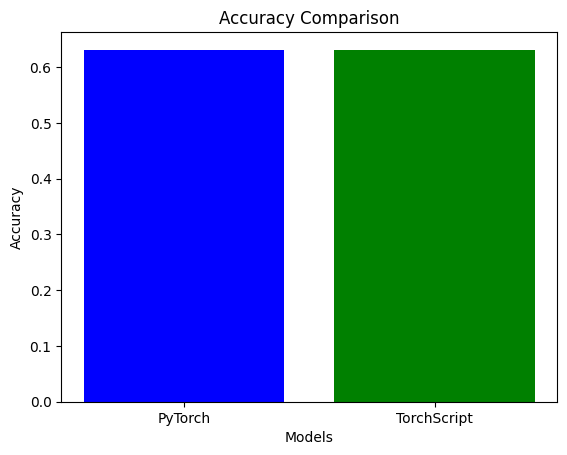

In [ ]:
accuracy_values = [accuracy_pytorch, accuracy_torchscript]
labels = ['PyTorch', 'TorchScript']

# Create a bar plot
plt.bar(labels, accuracy_values, color=['blue', 'green'])

# Add a title and labels to the plot
plt.title('Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Show the plot
plt.show()


There is no change in the accuracy for PyTorch and TorchScript.
So, TorchScript inference does not necessarily improve the accuracy of the model.

In [ ]:
# Define the number of inference runs
num_runs = 100

# Measure inference time for the PyTorch model
pytorch_inference_times = []
for _ in range(num_runs):
    with torch.no_grad():
        start_time = time.time()
        outputs = net(images)
        end_time = time.time()
        inference_time = end_time - start_time
        pytorch_inference_times.append(inference_time)

# Measure inference time for the TorchScript-optimized model
torchscript_inference_times = []
for _ in range(num_runs):
    with torch.no_grad():
        start_time = time.time()
        outputs = scripted_model(images)
        end_time = time.time()
        inference_time = end_time - start_time
        torchscript_inference_times.append(inference_time)

# Calculate and print average inference times
avg_pytorch_inference_time = sum(pytorch_inference_times) / num_runs
avg_torchscript_inference_time = sum(torchscript_inference_times) / num_runs

print(f"Average PyTorch Inference Time: {avg_pytorch_inference_time:.5f} seconds")
print(f"Average TorchScript Inference Time: {avg_torchscript_inference_time:.5f} seconds")


Average PyTorch Inference Time: 0.00937 seconds
Average TorchScript Inference Time: 0.00891 seconds


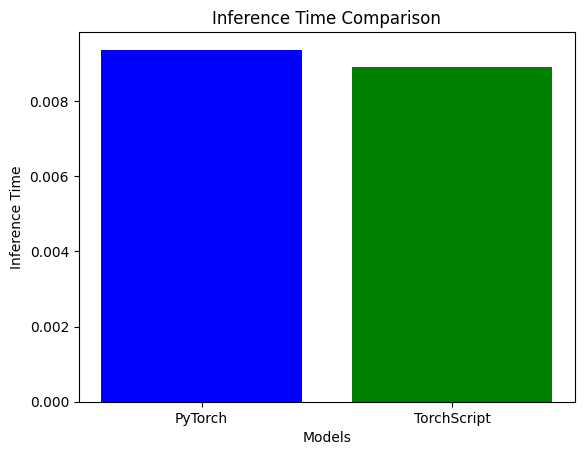

In [ ]:
time_values = [avg_pytorch_inference_time, avg_torchscript_inference_time]
labels = ['PyTorch', 'TorchScript']

# Create a bar plot
plt.bar(labels, time_values, color=['blue', 'green'])

# Add a title and labels to the plot
plt.title('Inference Time Comparison')
plt.xlabel('Models')
plt.ylabel('Inference Time')

# Show the plot
plt.show()

Inference time for TorchScript is slightly less than that of PyTorch.

In [ ]:
# Define data transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image
])

# Load the CIFAR-10 dataset (test set)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Choose an index to select an image from the dataset
image_index = 0

# Get the selected image and its label
input_image, label = testset[image_index]

# Print the label (class) of the selected image
print(f"Label: {label}")

Files already downloaded and verified
Label: 3


In [ ]:
# Measure latency for the PyTorch model
with torch.no_grad():
    start_time = time.time()
    output = net(input_image)
    end_time = time.time()
    latency_pytorch = end_time - start_time

# Measure latency for the TorchScript-optimized model
with torch.no_grad():
    start_time = time.time()
    output = scripted_model(input_image)
    latency_torchscript = end_time - start_time

# Compare model file sizes
original_model_size = os.path.getsize('original_model.pth')
torchscript_model_size = os.path.getsize('optimized_model.pt')

print(f"Latency (PyTorch): {latency_pytorch:.5f} seconds")
print(f"Latency (TorchScript): {latency_torchscript:.5f} seconds")
print(f"PyTorch Model Size: {original_model_size / (1024 * 1024):.2f} MB")
print(f"TorchScript Model Size: {torchscript_model_size / (1024 * 1024):.2f} MB")

Latency (PyTorch): 0.00686 seconds
Latency (TorchScript): 0.00210 seconds
PyTorch Model Size: 12.28 MB
TorchScript Model Size: 12.29 MB


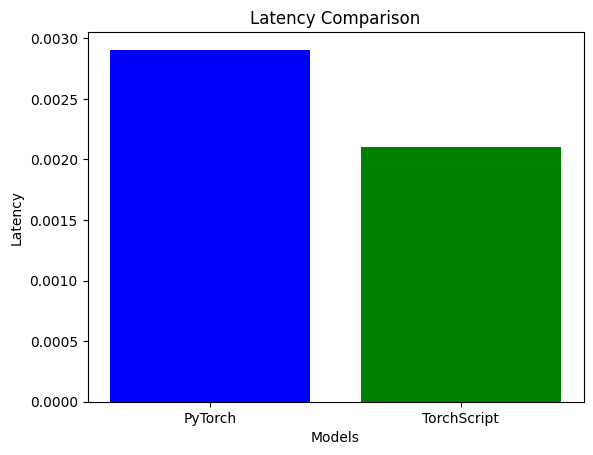

In [ ]:
latency_values = [latency_pytorch, latency_torchscript]
labels = ['PyTorch', 'TorchScript']

# Create a bar plot
plt.bar(labels, latency_values, color=['blue', 'green'])

# Add a title and labels to the plot
plt.title('Latency Comparison')
plt.xlabel('Models')
plt.ylabel('Latency')

# Show the plot
plt.show()

Latency in TorchScript is much less compared to the latency in PyTorch.

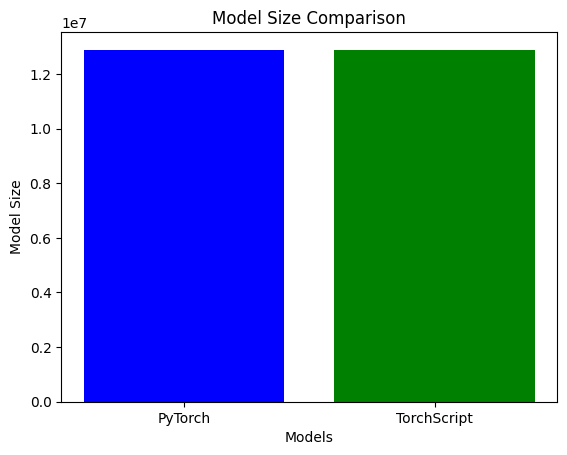

In [ ]:
latency_values = [original_model_size, torchscript_model_size]
labels = ['PyTorch', 'TorchScript']

# Create a bar plot
plt.bar(labels, latency_values, color=['blue', 'green'])

# Add a title and labels to the plot
plt.title('Model Size Comparison')
plt.xlabel('Models')
plt.ylabel('Model Size')

# Show the plot
plt.show()

The model size for this particular model is almost equal in PyTorch and TorchScript.

# Aproach 2: Low Resolution Quantization

In [ ]:
# Quantize the model
quantized_net = torch.quantization.quantize_dynamic(net, {nn.Conv2d, nn.Linear}, dtype=torch.qint8)
# Set the quantized 'quantized_net' model to evaluation mode
quantized_net.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): DynamicQuantizedLinear(in_features=12544, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=256, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [ ]:
# Prepare model quantization and convert to quantized version
quantized_net.qconfig = torch.quantization.get_default_qconfig("fbgemm")
torch.backends.quantized.engine = "fbgemm"
quantized_net = torch.quantization.prepare(quantized_net.cpu(), inplace=False)
quantized_net = torch.quantization.convert(quantized_net, inplace=False)

In [ ]:
# Check model size
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "quant_model.pth")
    size = round(os.path.getsize("quant_model.pth")/1e6)
    return size

net_size = print_model_size(net)
quant_size = print_model_size(quantized_net)

print(f'Size without quantization: {net_size} MB.')
print(f'Size with quantization: {quant_size} MB.')
print(f'Size ratio: {round(net_size/quant_size, 2)}')

Size without quantization: 13 MB.
Size with quantization: 3 MB.
Size ratio: 4.33


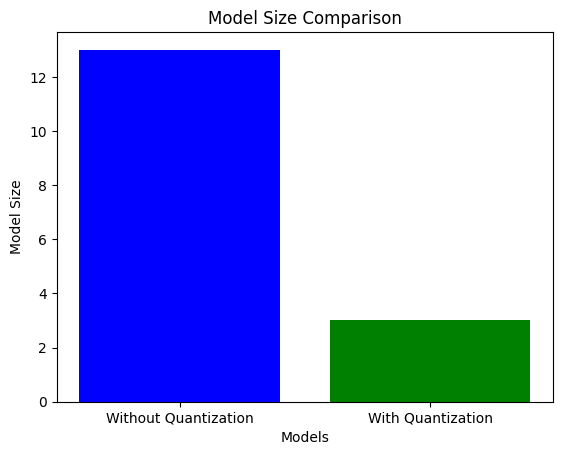

In [ ]:
size_values = [net_size, quant_size]
labels = ['Without Quantization', 'With Quantization']

# Create a bar plot
plt.bar(labels, size_values, color=['blue', 'green'])

# Add a title and labels to the plot
plt.title('Model Size Comparison')
plt.xlabel('Models')
plt.ylabel('Model Size')

# Show the plot
plt.show()

Model size is almost 1/4th when quantized.

In [ ]:
# Measure the time taken for inference with the original model
print("Floating point FP32")
fp32_time = timeit.timeit(lambda: net(input_image), number=10)
print(f"Average time per inference (FP32): {fp32_time / 10:.6f} seconds")

# Measure the time taken for inference with the quantized model
print("Quantized INT8")
quantized_time = timeit.timeit(lambda: quantized_net(input_image), number=10)
print(f"Average time per inference (INT8): {quantized_time / 10:.6f} seconds")

# Compare the latency between the original model and the quantized model
if fp32_time < quantized_time:
    print("Original model is faster.")
else:
    print("Quantized model is faster.")

Floating point FP32
Average time per inference (FP32): 0.002512 seconds
Quantized INT8
Average time per inference (INT8): 0.000844 seconds
Quantized model is faster.


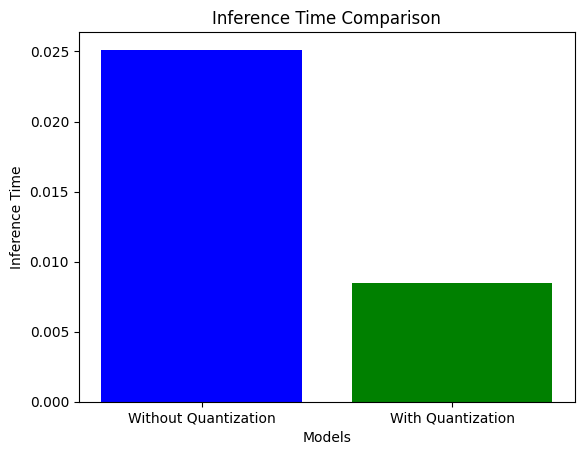

In [ ]:
time_values = [fp32_time, quantized_time]
labels = ['Without Quantization', 'With Quantization']

# Create a bar plot
plt.bar(labels, time_values, color=['blue', 'green'])

# Add a title and labels to the plot
plt.title('Inference Time Comparison')
plt.xlabel('Models')
plt.ylabel('Inference Time')

# Show the plot
plt.show()

Inference time with quantization is significantly less than that of without quantization.